In [4]:
import os
import  matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import show_hist # Useful if you wish to plot all hist and GPS target image
from rasterio.mask import mask
from shapely.geometry.point import Point
import shapely
import numpy as np
import csv
import fiona
from skimage.color import rgb2hsv

from tools_AA_IR import reading_gps_file, circle_sensor, plottingtemp_single_label_IR
from tools_AA_IR import path_IR, get_tif,get_value_IR 
from tools_AA_IR import circle_to_shape, readingIR , IR_mask, readingIR_all
from tools_AA import readingtemp_AA, slice_raw, path_sonde, name_sonde, plottingtemp_single_label
from tools_EL import readingtemp, plottingtemp
from tools_AA_VIS import readingVIS,VIS_mask , norm, requested_VIS_AOI,norm_tif,get_requested_tif,hsv
from tools_AA_VIS import hsv_tif,hsv

## Comparer les RGB normalisés et non normalisé

In [4]:
# Lecture image visible
# Ouverture et recupération des positions des sondes
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_coord = reading_gps_file(filename_Sensor_txt)
Sensor_coord # Contient les coord de toutes les sondes

,SensorName,x,y
0,S10,523628.71,5366296.81
1,S1,523654.74,5366287.75
2,S9,523692.47,5366276.57
3,S2,523660.22,5366258.91
4,S4,523636.075,5366245.545
5,S5,523641.825,5366220.67
6,S8,523649.33,5366188.02
7,S7,523696.655,5366174.0
8,S6,523694.05,5366209.93
9,S3-AIR,523624.949,5366313.764


In [15]:
#Recupere les noms des IR dans le dossier path, 
#par defaut = './traitement_PIREN/' et permet de 
#choisir n'importe quelle ortho avec son nom 

filetif = ['phase1']
 
ls_path_tif,filetif = get_tif(filetif)
Piren_VIS,Piren_VIS_ls= readingVIS(ls_path_tif,filetif)

In [4]:
for VIS in Piren_VIS :
    print(VIS) 
Piren_VIS.loc["VIS_array"]

Phase_1


Phase_1    [[[255, 255, 255, 255, 255, 255, 255, 255, 255...
Name: VIS_array, dtype: object

In [13]:
## creation d'un rayon de taille r autour des sensors
ls_sensor = Sensor_coord["SensorName"] # : toutes les sondes
ls_coord_circle,Shape_to_json,circle_name = circle_sensor(ls_sensor,Sensor_coord)

#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape

shapes,shapes_names = circle_to_shape(ls_coord_circle,Shape_to_json,circle_name)

## Creation de mask pour plusieurs images IR
ls_mask_image, ls_out_transform= VIS_mask(Piren_VIS.loc["VIS_src"],shapes,ls_coord_circle)


nombre de shapes 10


In [ ]:
# Plot 

fig_VIS,ax_VIS = plt.subplots(figsize=(50,50))
sub_fig = show(Piren_VIS.loc["VIS_array"],transform = Piren_VIS.loc["VIS_transform"][0])


## Optimisation

#### Non Normalisée

In [5]:

request_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
filetif = ['phase1']
requested_names, requested_shapes, ls_mask_image, ls_out_transform,Piren_VIS = requested_VIS_AOI(filetif,request_sensor)

['./traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif']
nombre de shapes 10


####  Normalisée

In [6]:
# NORMALISEE
request_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
filetif = ['.tif']
filetif_norm,requested_path = norm_tif(filetif)

requested_names_norm, requested_shapes_norm, ls_mask_image_norm, ls_out_transform_norm,Piren_VIS_norm = requested_VIS_AOI(filetif_norm,request_sensor)

./traitement_PIREN/vis_piren_phase_normalized.tif
['./traitement_PIREN/vis_piren_phase_normalized.tif']
nombre de shapes 10


#### HSV

In [7]:
request_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
filetif = ['.tif']
filetif_hsv,requested_path = hsv_tif(filetif)

requested_names_hsv, requested_shapes_hsv, ls_mask_image_hsv, ls_out_transform_hsv,Piren_VIS_hsv = requested_VIS_AOI(filetif_hsv,request_sensor)

./traitement_PIREN/vis_piren_phase_HSV.tif
['./traitement_PIREN/vis_piren_phase_HSV.tif']
nombre de shapes 10


In [ ]:
fig1,axrgb1 = plt.subplots(1,figsize=(50,50))
axrgb1.imshow(HSV_tif)

### PLOT 

In [2]:
## TOUTES LES MODIFICATIONS
lim_min = -10
lim_max = 20
len_shapes = len(requested_shapes)
step = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
fig_1,ax1=plt.subplots(len_shapes,3,figsize=(30,30),gridspec_kw = {'wspace':0, 'hspace':0})

for i, ax in enumerate(fig_1.axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
for k,mask_image in enumerate(ls_mask_image_norm[0]) :
    sub =show(mask_image, transform= ls_out_transform_norm[0],
              ax=ax1[k,0],title=requested_names_norm[k])#,vmin = lim_min,vmax = lim_max)
    
for k,mask_image in enumerate(ls_mask_image[0]) :
    sub =show(mask_image, transform= ls_out_transform[0],
              ax=ax1[k,1],title=requested_names[k])#,vmin = lim_min,vmax = lim_max)

for k,mask_image in enumerate(ls_mask_image_hsv[0]) :
    sub =show(mask_image, transform= ls_out_transform_hsv[0],
              ax=ax1[k,2],title=requested_names[k])#,vmin = lim_min,vmax = lim_max)
    


NameError: name 'requested_shapes' is not defined

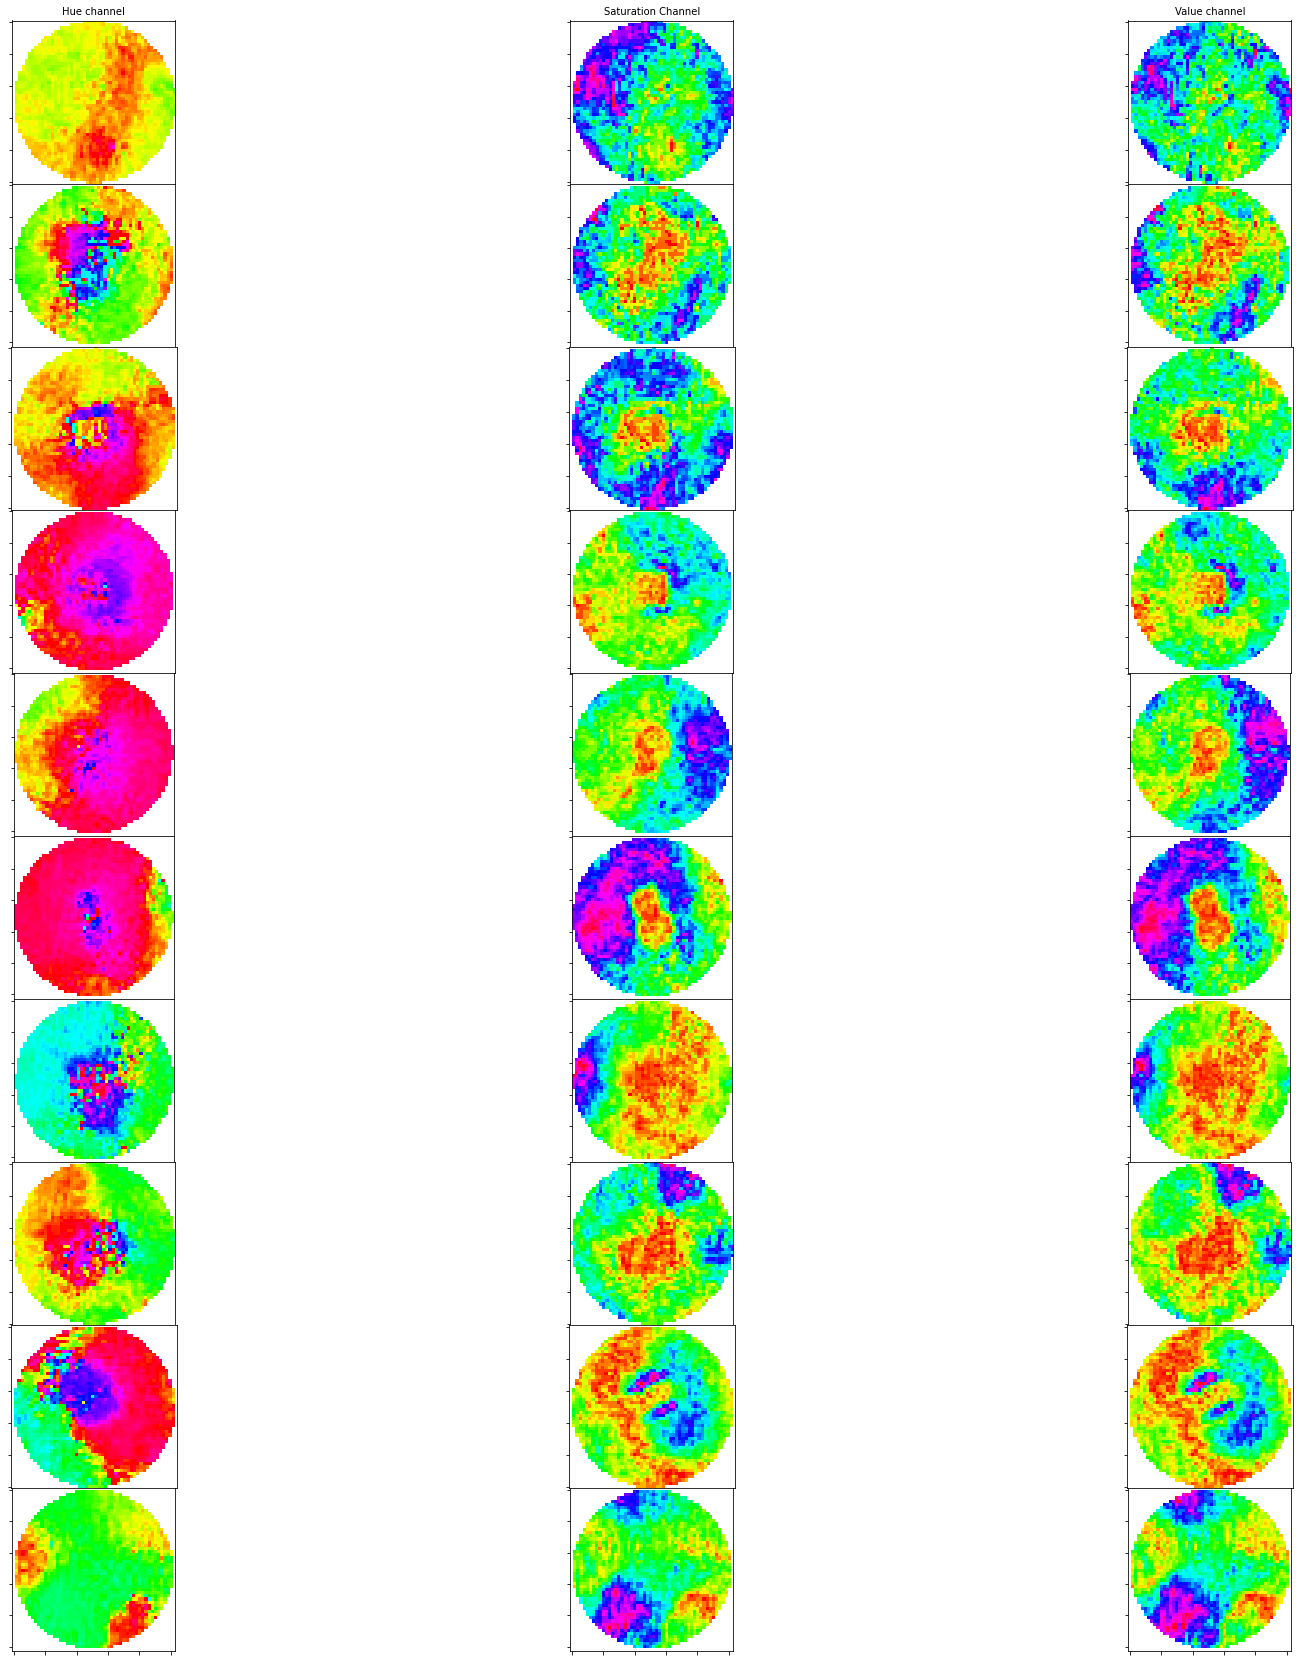

In [54]:
## HSV SEPAREE
lim_min = -10
lim_max = 20
len_shapes = len(requested_shapes)
step = 1

SMALL_SIZE = 5
MEDIUM_SIZE = 7
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
fig_1,ax1=plt.subplots(len_shapes,3,figsize=(30,30),gridspec_kw = {'wspace':0, 'hspace':0})

for i, ax in enumerate(fig_1.axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
for k,mask_image in enumerate(ls_mask_image_hsv[0]) :
    sub =ax1[k,0].imshow(mask_image[0],cmap='hsv')
    ax1[0,0].set_title("Hue channel")
                         
for k,mask_image in enumerate(ls_mask_image_hsv[0]) :
    sub =ax1[k,1].imshow(mask_image[1],cmap='hsv')
    ax1[0,1].set_title("Saturation Channel")

for k,mask_image in enumerate(ls_mask_image_hsv[0]) :
    sub =ax1[k,2].imshow(mask_image[2],cmap='hsv')
    ax1[0,2].set_title("Value channel")
    


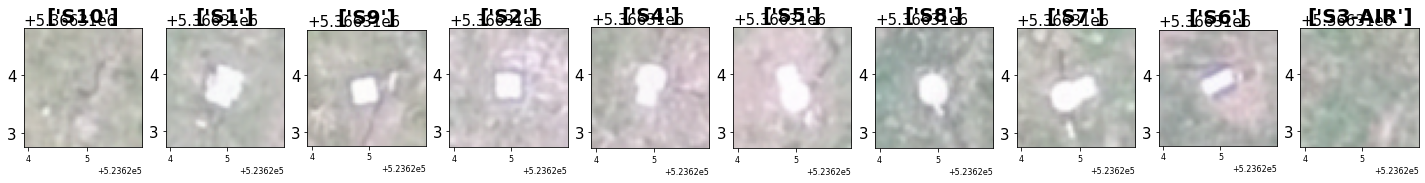

In [49]:
## Plot d'un echantillon i = IR , k = Sondes
lim_min = -10
lim_max = 20
len_shapes = len(requested_shapes)
step = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig_IR,axtemp=plt.subplots(1,len_shapes,figsize=(25,25))

for k,mask_image in enumerate(ls_mask_image[0]) :
    sub =show(mask_image, transform= ls_out_transform[0],
              ax=axtemp[k],title=requested_names[k])#,vmin = lim_min,vmax = lim_max)

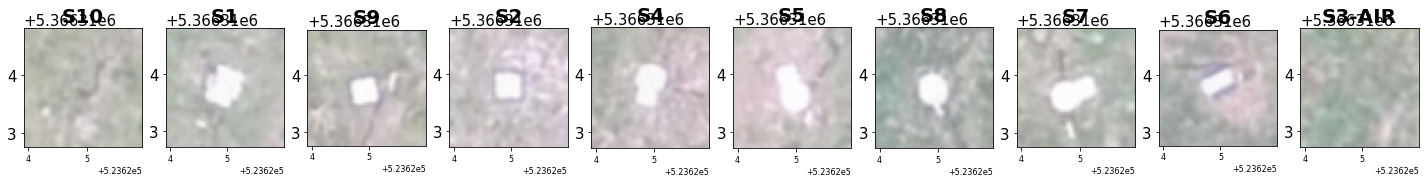

In [17]:
## PLOT NORMALISE
lim_min = -10
lim_max = 20
len_shapes = len(requested_shapes)
step = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig_IR,axtemp=plt.subplots(1,len_shapes,figsize=(50,10))

for k,mask_image in enumerate(ls_mask_image[0]) :
    sub =show(mask_image, transform= ls_out_transform_norm[0],
              ax=axtemp[k],title=requested_names_norm[k])#,vmin = lim_min,vmax = lim_max)

In [ ]:
## PLOT HSV
lim_min = -10
lim_max = 20
len_shapes = len(requested_shapes)
step = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig_IR,axtemp=plt.subplots(1,len_shapes,figsize=(25,25))
for k,mask_image in enumerate(ls_mask_image_hsv[0]) :
    sub =show(mask_image, transform= ls_out_transform_hsv[0],
              ax=ax1[k],title=requested_names[k])#,vmin = lim_min,vmax = lim_max)
    

Text(0.5, 1.0, 'Blue')

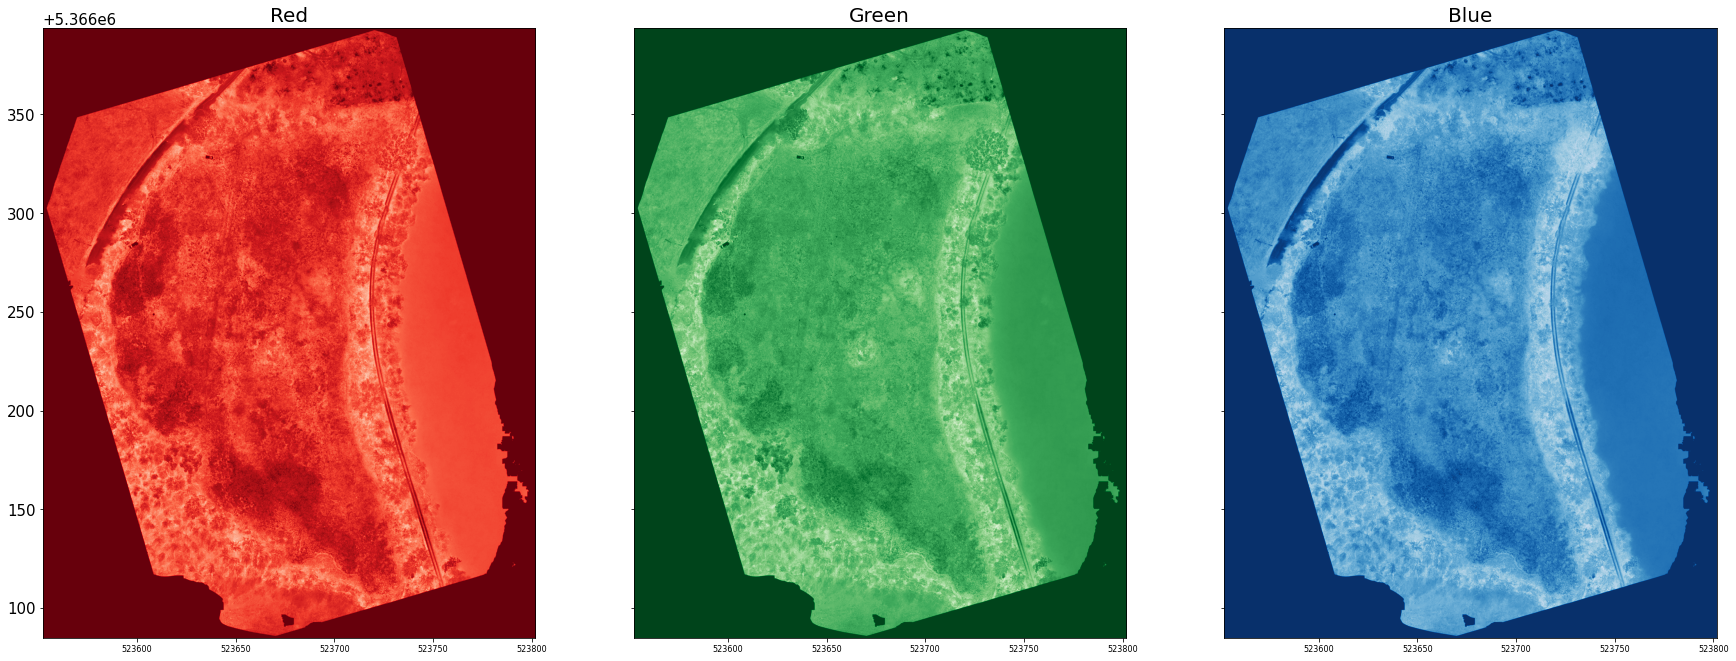

In [59]:

#fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 15), sharey=True)

# Plot Red, Green and Blue (rgb)
#show((Ortho, 1), cmap='Reds', ax=ax1)
#show((Ortho, 2), cmap='Greens', ax=ax2)
#show((Ortho, 3), cmap='Blues', ax=ax3)

# Add titles
#ax1.set_title("Red")
#ax2.set_title("Green")
#ax3.set_title("Blue")

### Histogramme 

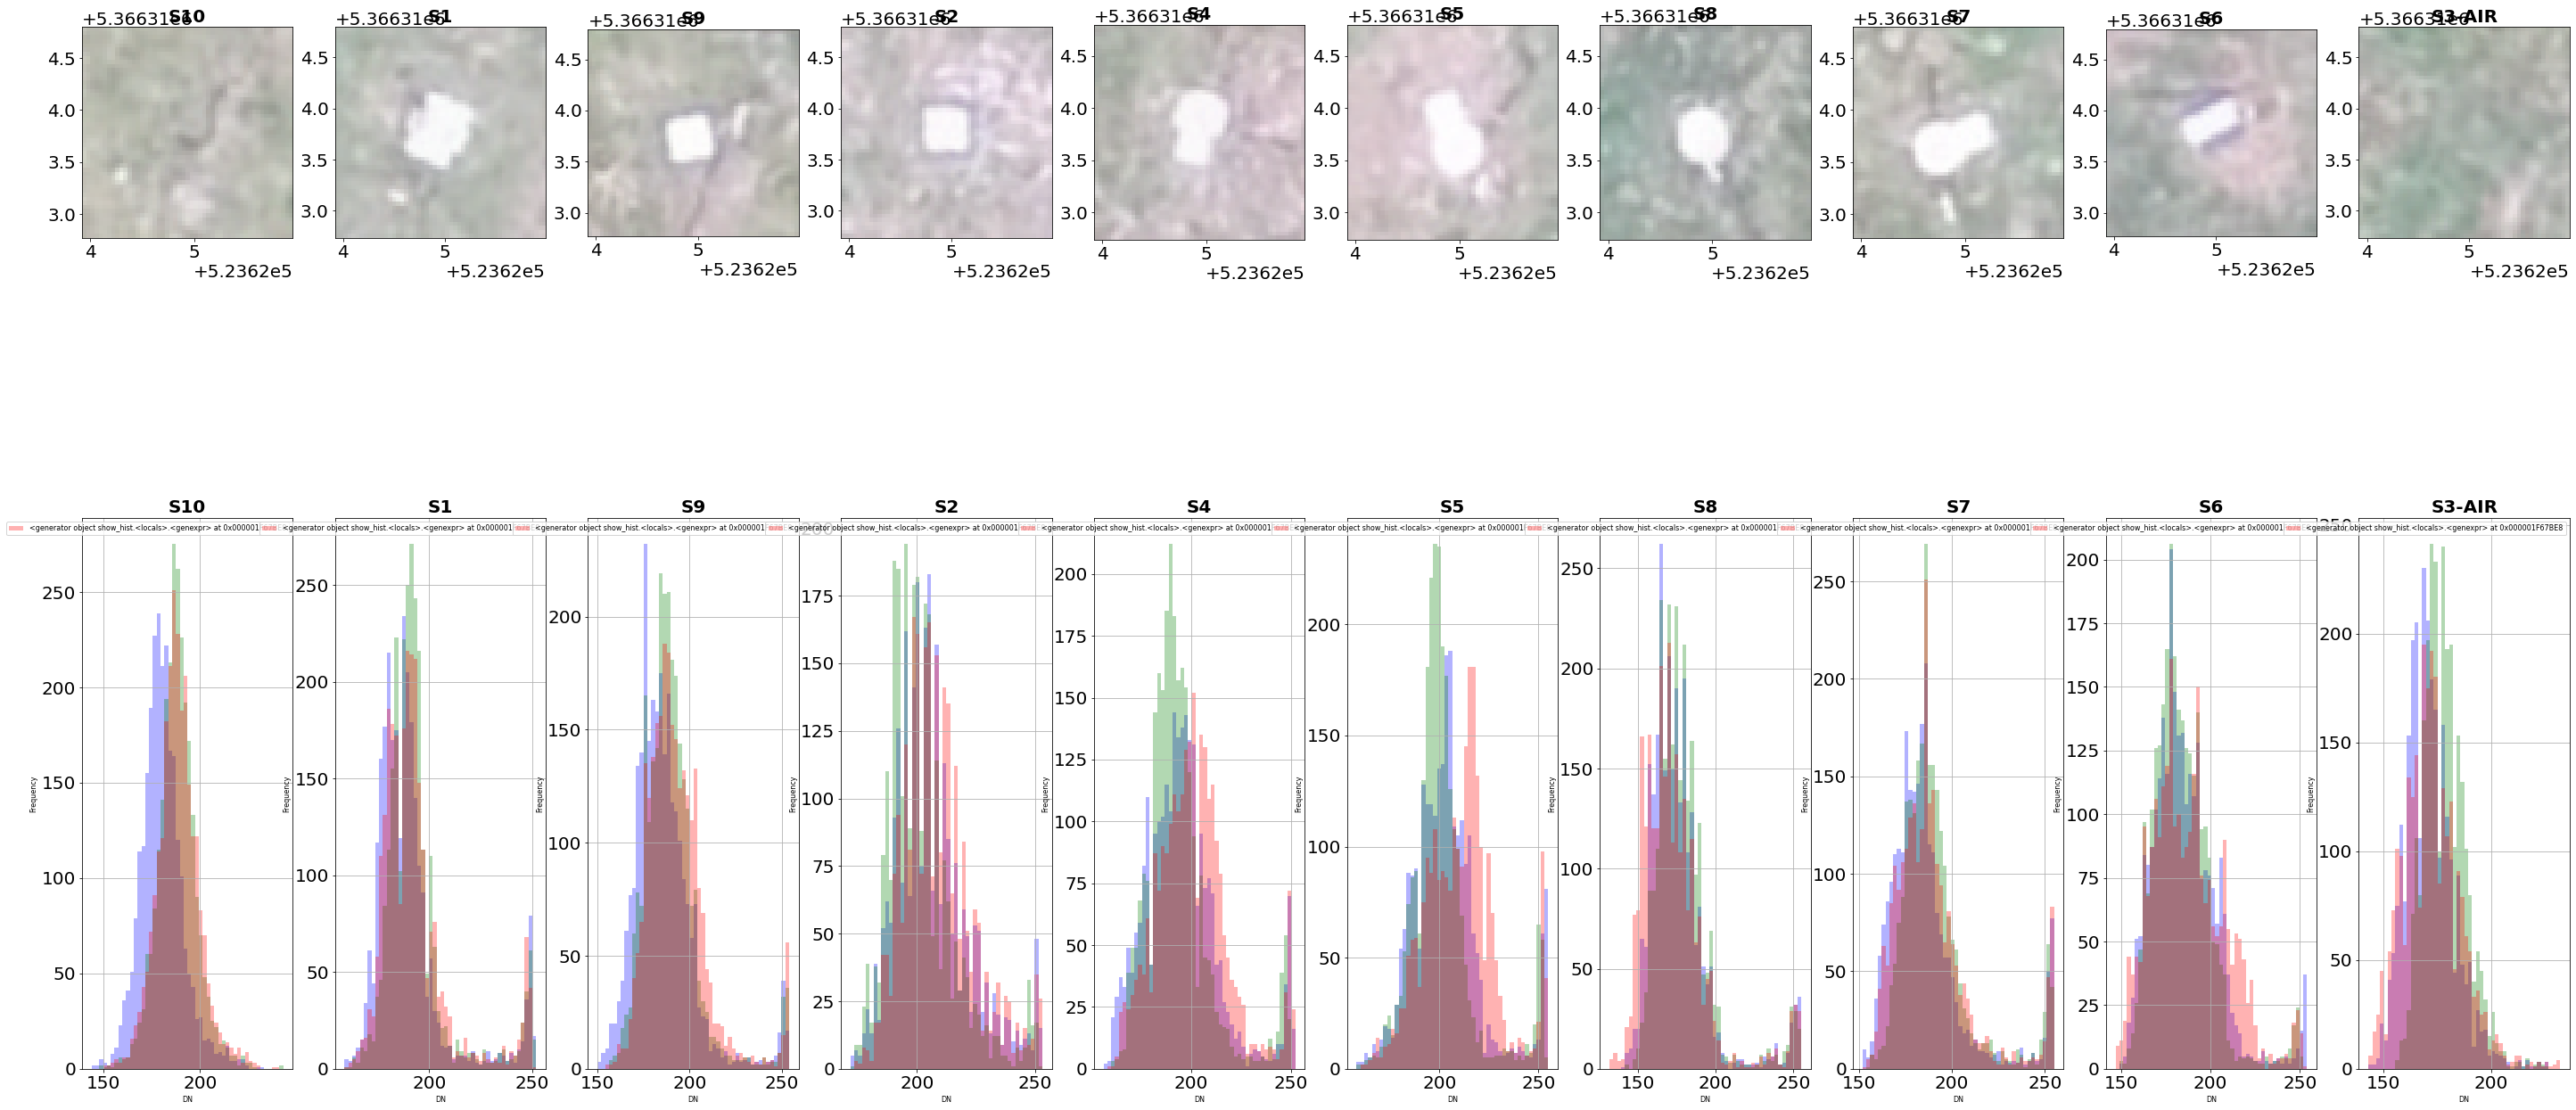

In [34]:
## Plot d'un echantillon i = IR , k = Sondes
len_shapes = len(requested_shapes)

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig_IR,(axtemp)=plt.subplots(2,len_shapes,figsize=(50,25))

for k,mask_image in enumerate(ls_mask_image[0]) :
    sub =show(mask_image, transform= ls_out_transform[0],
              ax=axtemp[0,k],title=requested_names[k])#,vmin = lim_min,vmax = lim_max)
    sub_hist = show_hist(mask_image,bins=50, histtype='stepfilled', lw=0.0, stacked=False,
                         ax=axtemp[1,k], alpha=0.3, title=requested_names[k])

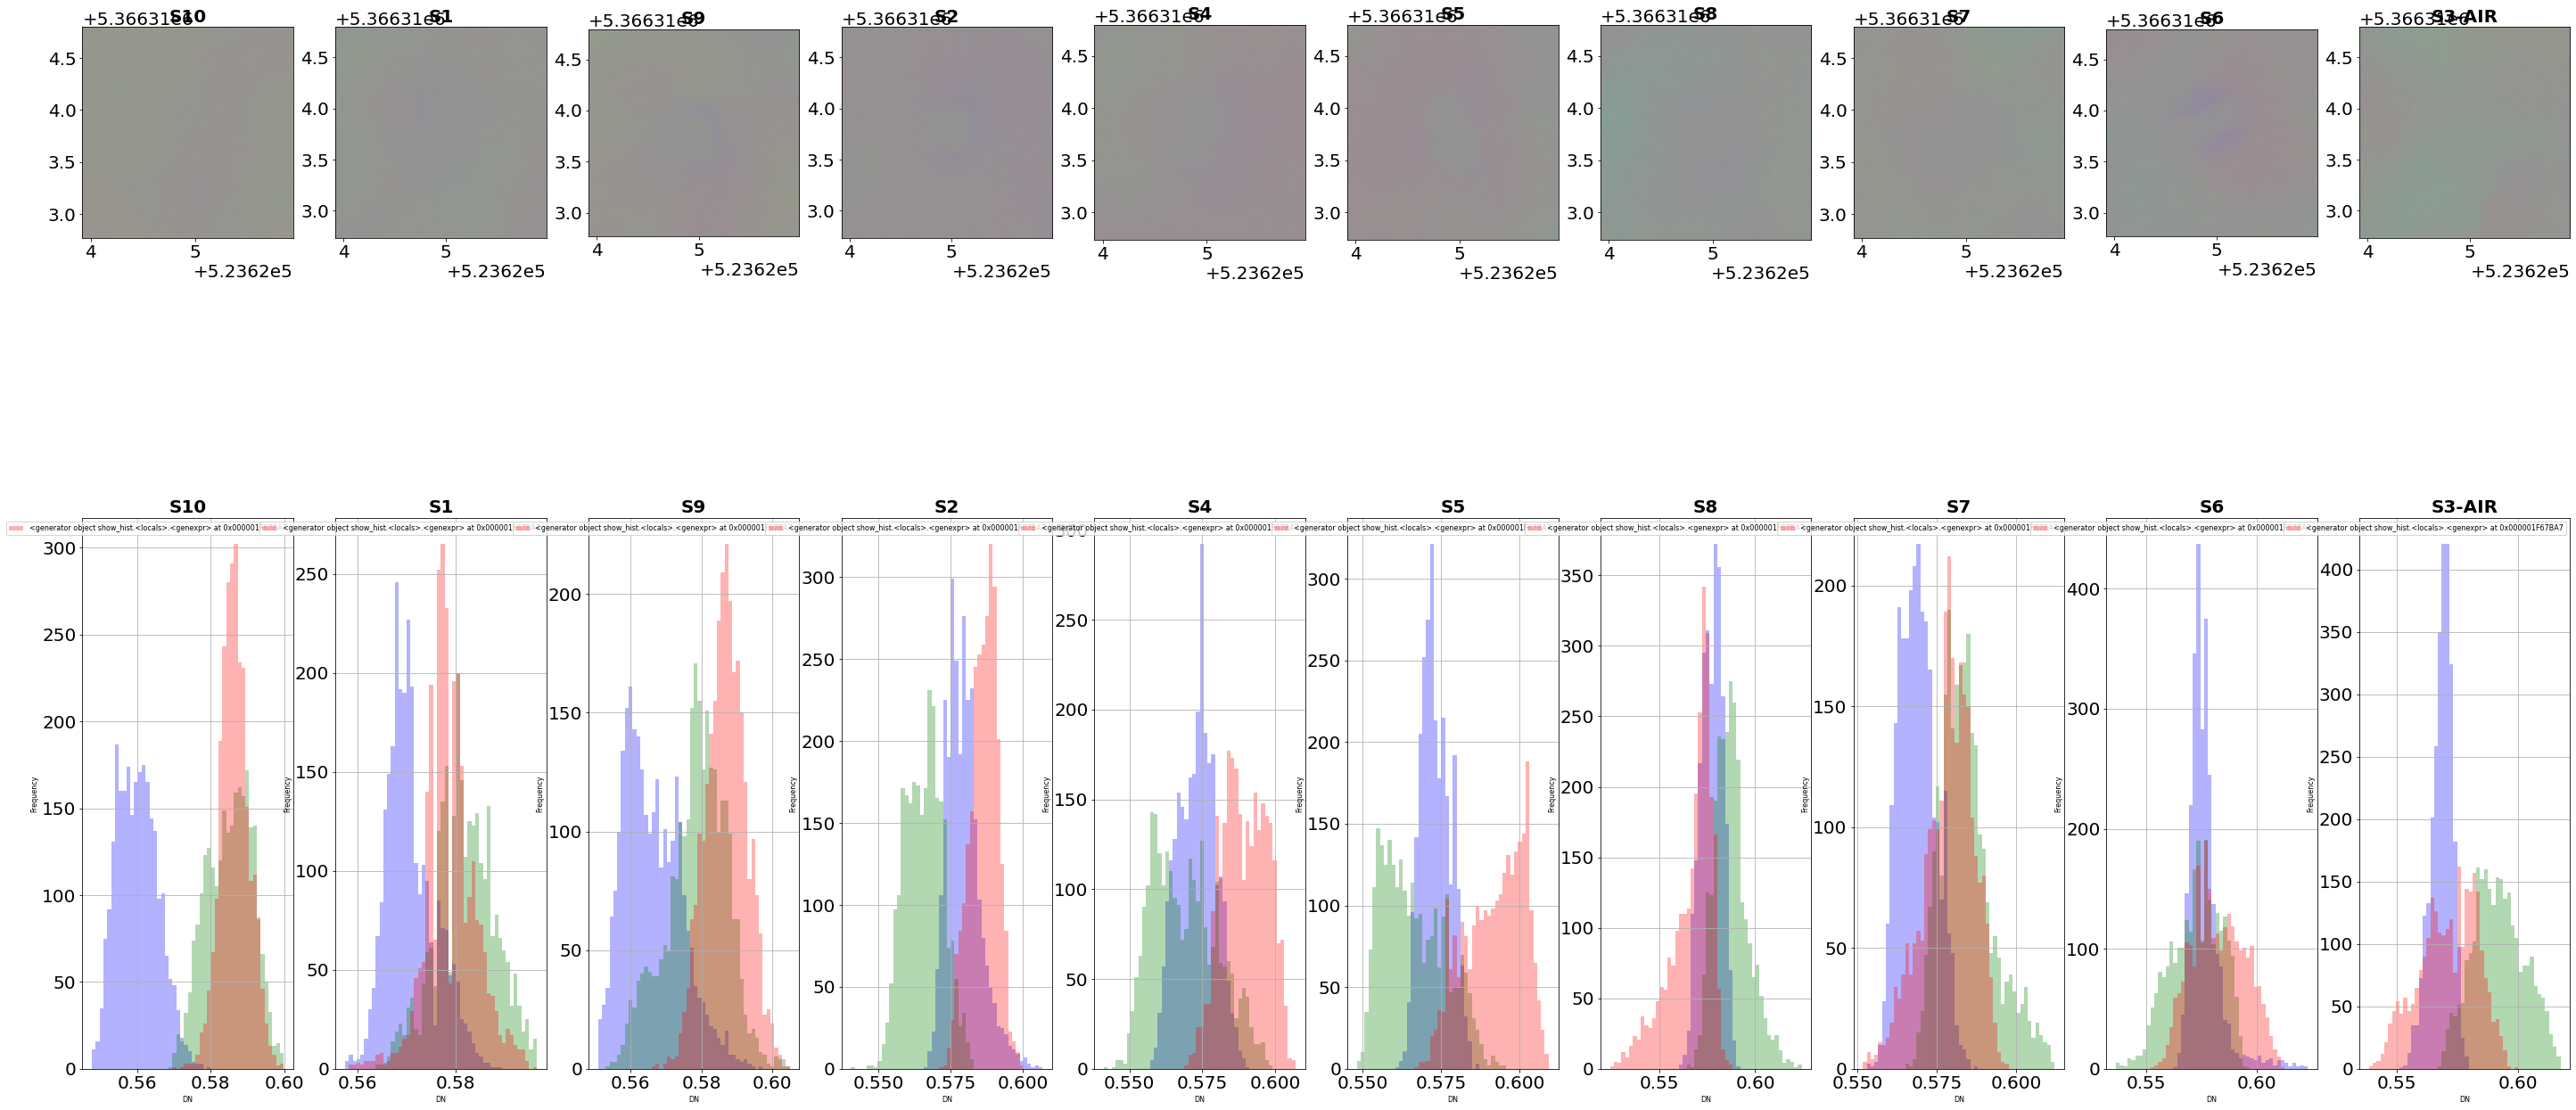

In [33]:
## Plot d'un echantillon i = IR , k = Sondes
len_shapes = len(requested_shapes)

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig_IR,(axtemp)=plt.subplots(2,len_shapes,figsize=(50,25))

for k,mask_image in enumerate(ls_mask_image_norm[0]) :
    sub =show(mask_image, transform= ls_out_transform[0],
              ax=axtemp[0,k],title=requested_names[k])#,vmin = lim_min,vmax = lim_max)
    sub_hist = show_hist(mask_image,bins=50, histtype='stepfilled', lw=0.0, stacked=False,
                         ax=axtemp[1,k], alpha=0.3, title=requested_names[k])

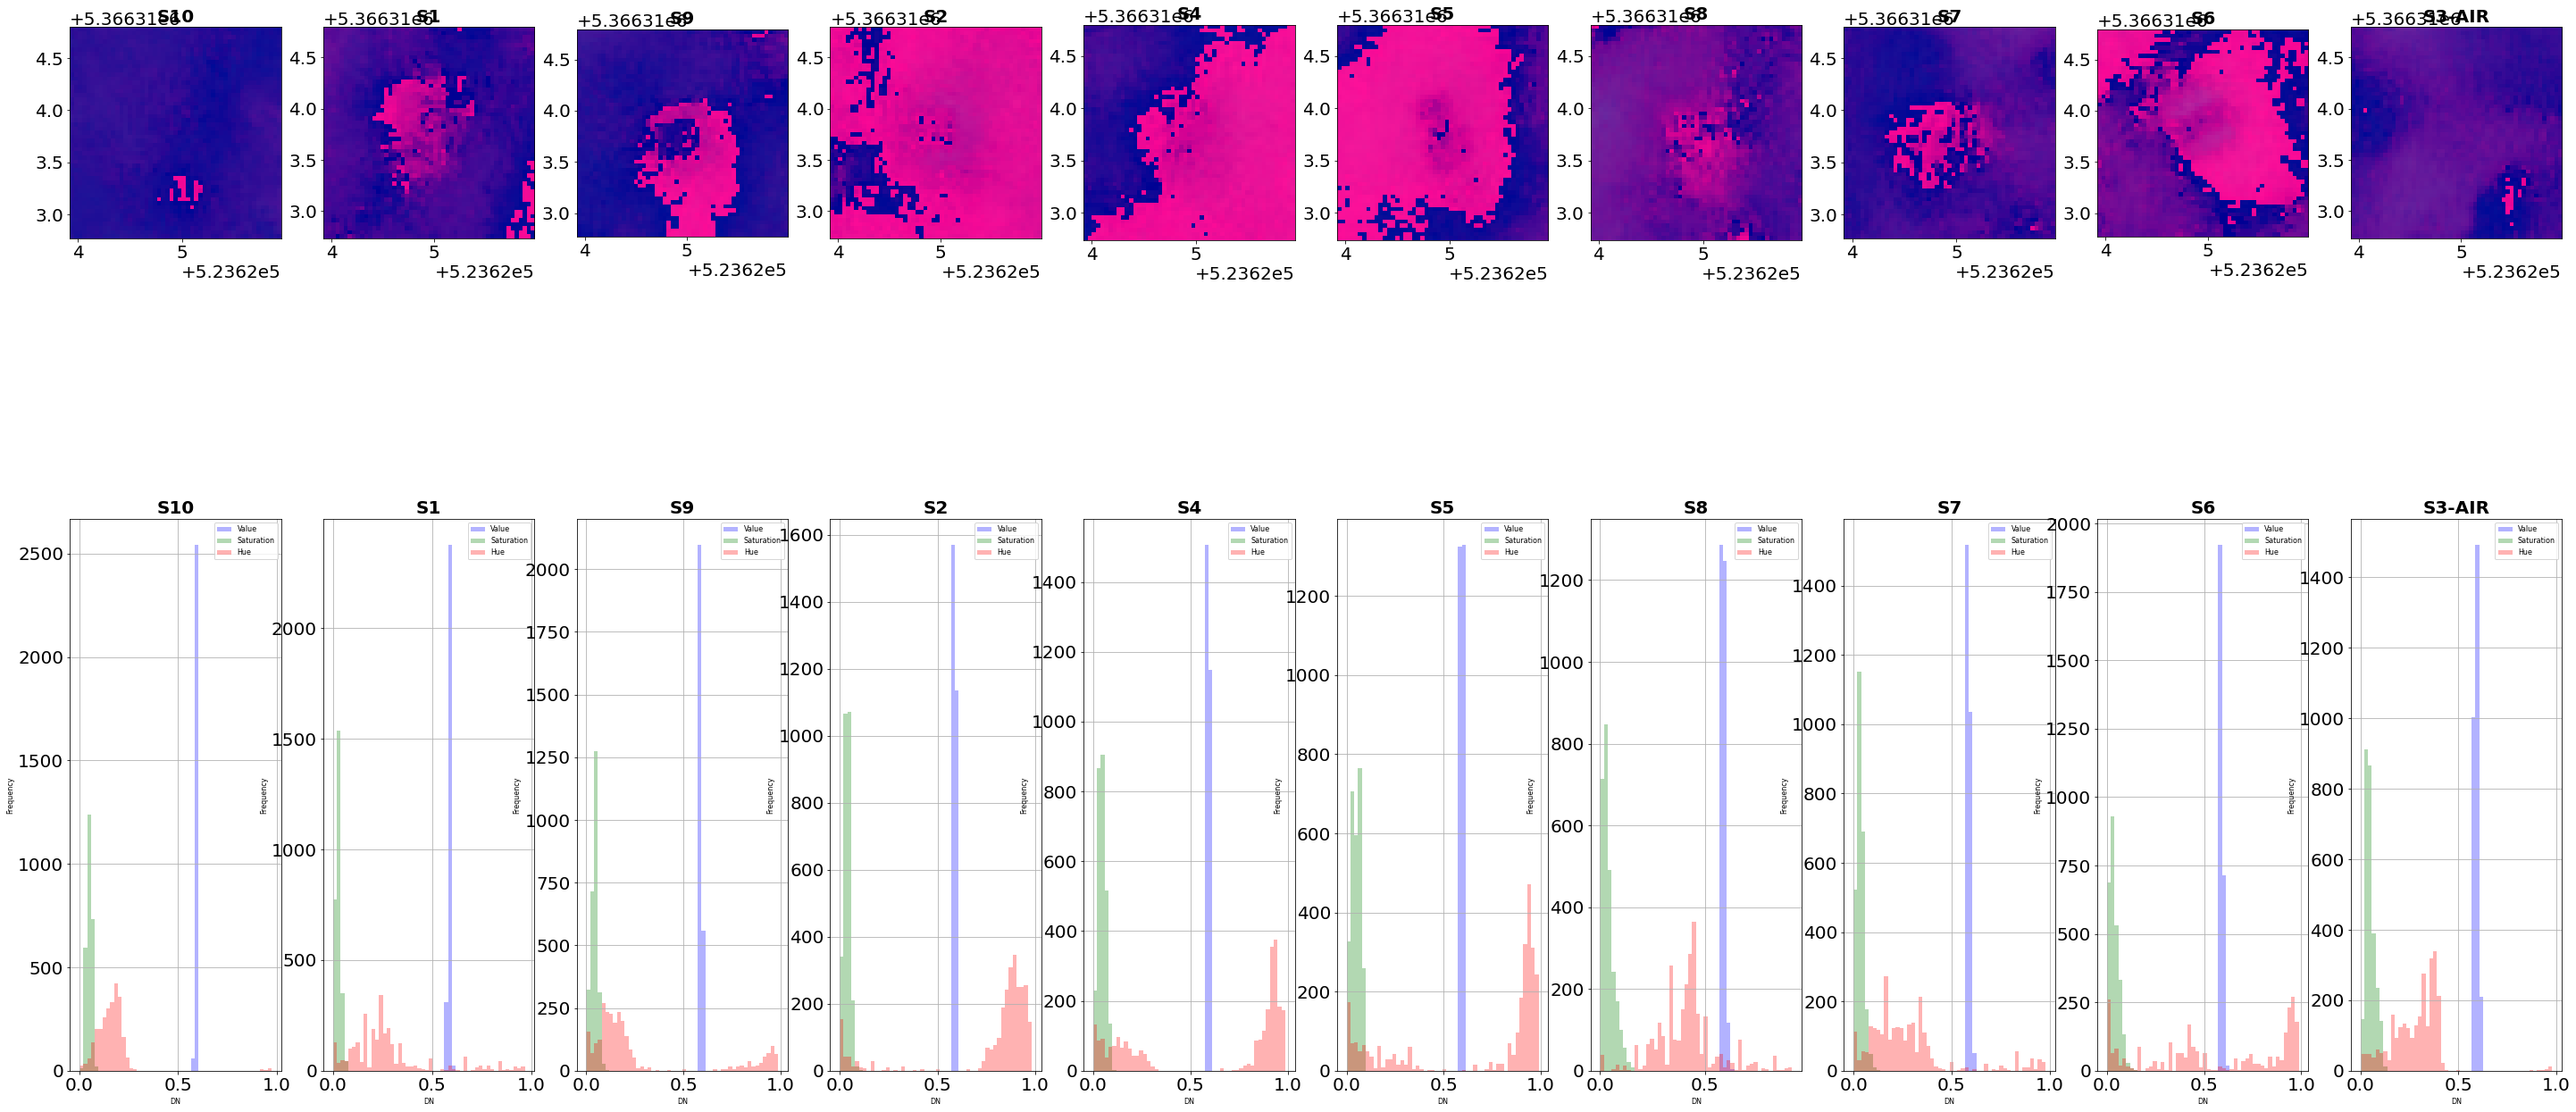

In [36]:
## Plot d'un echantillon i = IR , k = Sondes
len_shapes = len(requested_shapes)

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig_IR,(axtemp)=plt.subplots(2,len_shapes,figsize=(50,25))

for k,mask_image in enumerate(ls_mask_image_hsv[0]) :
    sub =show(mask_image, transform= ls_out_transform[0],
              ax=axtemp[0,k],title=requested_names[k])#,vmin = lim_min,vmax = lim_max)
    sub_hist = show_hist(mask_image,bins=50, histtype='stepfilled', lw=0.0, stacked=False,
                         ax=axtemp[1,k], alpha=0.3, title=requested_names[k],label=["Hue","Saturation","Value"])

## ANNEXE

In [10]:
Piren_VIS.loc["VIS_transform"][0]

Affine(0.039665999999996815, 0.0, 523552.2443436172,
       0.0, -0.03966599999997521, 5366393.889445229)

In [6]:
filetif = ['phase1']
ls_path_tif,filetif = get_tif(filetif)
for path_tif in ls_path_tif :
    VIS_src= rio.open(os.path.join(path_tif))


Red_N,Green_N,Blue_N = norm(VIS_src)

profile = {
    "driver": "GTiff",
    "count": 3,
    "height": VIS_src.shape[0],
    "width": VIS_src.shape[1],
    'dtype': 'float32',
    'transform': VIS_src.transform,
    "meta" : VIS_src.meta ,
    "bounds": VIS_src.bounds ,
    "crs": VIS_src.crs ,
    "res": VIS_src.res }


In [ ]:
profile = {
        "driver": "GTiff",
        "count": 3,
        "height": Piren_VIS_n.loc["VIS_src"][0].shape[0],
        "width": Piren_VIS_n.loc["VIS_src"][0].shape[1],
        'dtype': 'float32',
        'transform': Piren_VIS_n.loc["VIS_src"][0].transform,
        "meta" : Piren_VIS_n.loc["VIS_src"][0].meta ,
        "bounds": Piren_VIS_n.loc["VIS_src"][0].bounds ,
        "crs": Piren_VIS_n.loc["VIS_src"][0].crs ,
        "res": Piren_VIS_n.loc["VIS_src"][0].res }
        

with rio.open(
        './example_norm.tif', 'w',
        **profile) as dst: # count : nombre de band
    for k, arr in [(1, Red_N), (2, Green_N), (3, Blue_N)]:
        dst.write(arr.astype(rio.float32), indexes=k)

In [3]:
path_vis = ['./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif', './traitement_PIREN/002_7H29_ortho_UTM31N_IR.tif', './traitement_PIREN/003_8H22_ortho_UTM31N_IR.tif']
a = ('./traitement_PIREN/003_8H22_ortho_UTM31N_IR.tif')
k = 0
while path_vis[k].find(a)!=0 & k<=len(path_vis)-1 :
    k+=1
    print(k)
path_final = path_vis[k]
if path_final != a :
    b = True
else : 
    b = False

path_final
b

1
2


False

nombre de shapes 10


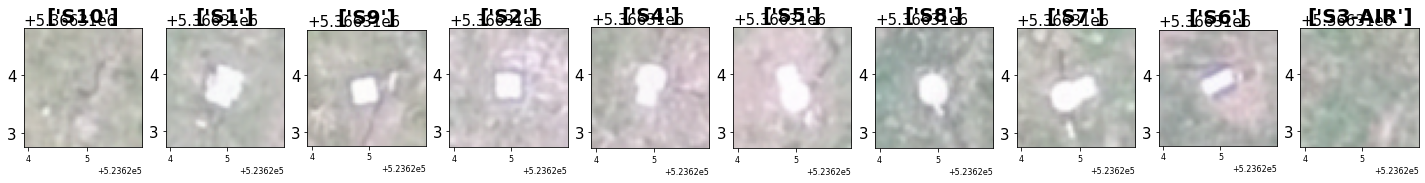

In [5]:
#Methode pour discriminer les sondes

request_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
requested_VIS = Piren_VIS


## creation d'un rayon de taille r autour des sensors
ls_sensor = Sensor_coord["SensorName"] # : toutes les sondes
ls_coord_circle,Shape_to_json,circle_name = circle_sensor(ls_sensor,Sensor_coord)

#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape

shapes,shapes_names = circle_to_shape(ls_coord_circle,Shape_to_json,circle_name)



requested_names  =  []
requested_shapes =  []
requested_ls_coord_circle = []
for i,names in enumerate(shapes_names) :
    for k in range(len(request_sensor)) :  
        if names == request_sensor[k] :
            requested_names.append(names)
            requested_shapes.append(shapes[i])
            requested_ls_coord_circle.append(ls_coord_circle[i])
            
## Creation de mask pour plusieurs images IR
ls_mask_image, ls_out_transform= VIS_mask(Piren_VIS.loc["VIS_src"],shapes,ls_coord_circle)

## Plot d'un echantillon i = IR , k = Sondes
lim_min = -10
lim_max = 20
len_shapes = len(shapes)
step = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


if len_shapes == 1 : 
    
    fig_IR,axtemp=plt.subplots(1,figsize=(25,25))
    
    for k,mask_image in enumerate(ls_mask_image[0]) :
        sub =show(mask_image, transform= ls_out_transform[0],
                  ax=axtemp,title=[requested_names[k]])#,vmin = lim_min,vmax = lim_max)

else :
        
    fig_IR,axtemp=plt.subplots(1,len_shapes,figsize=(25,25))

    for k,mask_image in enumerate(ls_mask_image[0]) :
        sub =show(mask_image, transform= ls_out_transform[0],
                  ax=axtemp[k],title=[requested_names[k]])#,vmin = lim_min,vmax = lim_max)

In [7]:
# Lecture de chaque bande
Ortho = Piren_VIS.loc["VIS_src"][0] 
Red=Ortho.read(1)
Green=Ortho.read(2)
Blue=Ortho.read(3)

# Normalisation 
Red=Red.astype('f4')
Green=Green.astype('f4')
Blue=Blue.astype('f4')
RGB= np.dstack((Red, Green, Blue)) # On refait un pseudo RGB
RGB=RGB.astype('float32') # Je veut juste etre sur que c'est du float


Red_N=Red/np.sqrt(Red**2 + Green**2 + Blue**2);
Green_N=Green/np.sqrt(Red**2 + Green**2 + Blue**2);
Blue_N=Blue/np.sqrt(Red**2 + Green**2 + Blue**2);
RGB_N = np.dstack((Red_N, Green_N, Blue_N)) # RGB Normalisee

In [ ]:

fig1,axrgb1 = plt.subplots(1,figsize=(50,50))
axrgb1.imshow(RGB_N.astype('float32'))

nombre de shapes 10


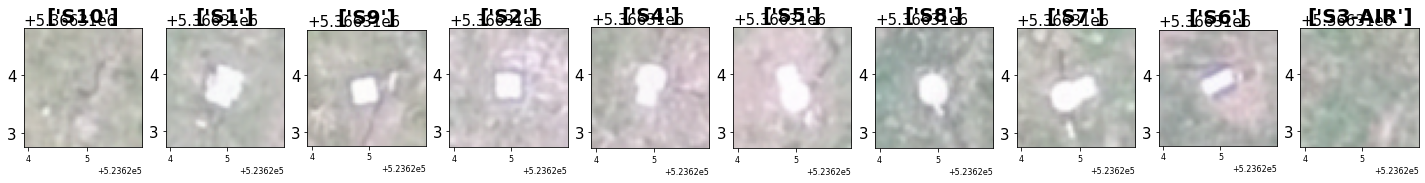

In [4]:
#Methode NORMALISEE 
#Recupere les noms des IR dans le dossier path, 
#par defaut = './traitement_PIREN/' et permet de 
#choisir n'importe quelle ortho avec son nom 

filetif = ['phase1']
 
ls_path_tif,filetif = get_tif(filetif)
Piren_VIS_n,Piren_VIS_ls_n= readingVIS_norm(ls_path_tif,filetif)

request_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
requested_VIS = Piren_VIS_n

# Lecture image visible
# Ouverture et recupération des positions des sondes
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_coord = reading_gps_file(filename_Sensor_txt)
Sensor_coord # Contient les coord de toutes les sondes

## creation d'un rayon de taille r autour des sensors
ls_sensor = Sensor_coord["SensorName"] # : toutes les sondes
ls_coord_circle,Shape_to_json,circle_name = circle_sensor(ls_sensor,Sensor_coord)

#Creat a shape in GeoJSON format in order to be read with rio and 
#serve as mask to crop selected area in the shape

shapes,shapes_names = circle_to_shape(ls_coord_circle,Shape_to_json,circle_name)



requested_names  =  []
requested_shapes =  []
requested_ls_coord_circle = []
for i,names in enumerate(shapes_names) :
    for k in range(len(request_sensor)) :  
        if names == request_sensor[k] :
            requested_names.append(names)
            requested_shapes.append(shapes[i])
            requested_ls_coord_circle.append(ls_coord_circle[i])


## Creation de mask pour plusieurs images IR
ls_mask_image, ls_out_transform= VIS_mask(Piren_VIS_n.loc["VIS_src"],shapes,ls_coord_circle)



## Plot d'un echantillon i = IR , k = Sondes
lim_min = -10
lim_max = 20
len_shapes = len(shapes)
step = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title !!! 
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


if len_shapes == 1 : 
    
    fig_IR,axtemp=plt.subplots(1,figsize=(25,25))
    
    for k,mask_image in enumerate(ls_mask_image[0]) :
        sub =show(mask_image, transform= ls_out_transform[0],
                  ax=axtemp,title=[requested_names[k]])#,vmin = lim_min,vmax = lim_max)

else :
        
    fig_IR,axtemp=plt.subplots(1,len_shapes,figsize=(25,25))

    for k,mask_image in enumerate(ls_mask_image[0]) :
        sub =show(mask_image, transform= ls_out_transform[0],
                  ax=axtemp[k],title=[requested_names[k]])#,vmin = lim_min,vmax = lim_max)

In [125]:
Piren_VIS_n.loc["VIS_src"][0].transform


Affine(0.039665999999996815, 0.0, 523552.2443436172,
       0.0, -0.03966599999997521, 5366393.889445229)

In [138]:
profile = {
        "driver": "GTiff",
        "count": 3,
        "height": Piren_VIS_n.loc["VIS_src"][0].shape[0],
        "width": Piren_VIS_n.loc["VIS_src"][0].shape[1],
        'dtype': 'float32',
        'transform': Piren_VIS_n.loc["VIS_src"][0].transform,
        "meta" : Piren_VIS_n.loc["VIS_src"][0].meta ,
        "bounds": Piren_VIS_n.loc["VIS_src"][0].bounds ,
        "crs": Piren_VIS_n.loc["VIS_src"][0].crs ,
        "res": Piren_VIS_n.loc["VIS_src"][0].res }
        

with rio.open(
        './example_norm.tif', 'w',
        **profile) as dst: # count : nombre de band
    for k, arr in [(1, Red_N), (2, Green_N), (3, Blue_N)]:
        dst.write(arr.astype(rio.float32), indexes=k)

In [129]:
test_src.close()